In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

E:\Python\PY3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
def my_conv2_transpose(input_tensor,output_size,output_channel,kernel_size,strides=[1,1,1,1]):
    '''
    反卷积的使用，参考：
        https://riptutorial.com/tensorflow/example/29767/using-tf-nn-conv2d-transpose-for-arbitary-batch-sizes-and-with-automatic-output-shape-calculation-
    '''
    k_h,k_w = kernel_size
    input_tensor_channel = input_tensor.get_shape().as_list()[3]
    
    # 反卷积的w
    trans_w = tf.Variable(tf.truncated_normal(shape=[k_h,k_w,
                                                     output_channel,
                                                     input_tensor_channel],
                                              dtype=tf.float32))
    # 反卷积的bias的shape就是一个输出的shape
    trans_b = tf.Variable(tf.constant(value=0.1,shape=[output_channel],dtype=tf.float32))
    
    # outputshape
    output_h,output_w = output_size
    output_shape=tf.stack([tf.shape(input_tensor)[0],
                           output_h,
                           output_w,
                           output_channel])
    
    # 反卷积
    upconv = tf.nn.conv2d_transpose(input_tensor,
                                    filter=trans_w,
                                    output_shape=output_shape,
                                    strides=strides)
    output = tf.nn.bias_add(upconv,trans_b)
    
    return output

In [62]:
tf.reset_default_graph()
input_tensor = tf.placeholder(shape=[None,256,256,1],dtype=tf.float32)

with slim.arg_scope([slim.conv2d],
                    padding='SAME',
                    activation_fn=tf.nn.relu):
    with tf.variable_scope('down_1'):
        d1_conv1 = slim.conv2d(input_tensor,num_outputs=64,kernel_size=3)
        d1_conv2 = slim.conv2d(d1_conv1,num_outputs=64,kernel_size=3)
        d1_max1 = slim.max_pool2d(d1_conv2,kernel_size=2,stride=2)
    
    with tf.variable_scope('down_2'):
        d2_conv1 = slim.conv2d(d1_max1,num_outputs=128,kernel_size=3)
        d2_conv2 = slim.conv2d(d2_conv1,num_outputs=128,kernel_size=3)
        d2_max1 = slim.max_pool2d(d2_conv2,kernel_size=2,stride=2)
    
    with tf.variable_scope('down_3'):
        d3_conv1 = slim.conv2d(d2_max1,num_outputs=256,kernel_size=3)
        d3_conv2 = slim.conv2d(d3_conv1,num_outputs=256,kernel_size=3)
        d3_max1 = slim.max_pool2d(d3_conv2,kernel_size=2,stride=2)
    
    with tf.variable_scope('down_4'):
        d4_conv1 = slim.conv2d(d3_max1,num_outputs=512,kernel_size=3)
        d4_conv2 = slim.conv2d(d4_conv1,num_outputs=512,kernel_size=3)
        d4_max1 = slim.max_pool2d(d4_conv2,kernel_size=2,stride=2)
    
    with tf.variable_scope('down_5'):
        d5_conv1 = slim.conv2d(d4_max1,num_outputs=1024,kernel_size=3)
        d5_conv2 = slim.conv2d(d5_conv1,num_outputs=1024,kernel_size=3)
    
    with tf.variable_scope('up_1'):
        up1_h = d5_conv2.get_shape().as_list()[1]*2
        up1_w = d5_conv2.get_shape().as_list()[2]*2
        
        up1 = my_conv2_transpose(input_tensor=d5_conv2,
                                 output_size=(up1_h,up1_w),
                                 output_channel=512,
                                 kernel_size=(3,3))
        
        concate_1 = tf.concat([up1,d4_conv2],axis=3)
        
        u1_conv1 = slim.conv2d(concate_1,num_outputs=512,kernel_size=3)
        u1_conv2 = slim.conv2d(u1_conv1,num_outputs=512,kernel_size=3)
    
    with tf.variable_scope('up_2'):
        up2_h = u1_conv2.get_shape().as_list()[1]*2
        up2_w = u1_conv2.get_shape().as_list()[2]*2
        
        up2 = my_conv2_transpose(u1_conv2,(up2_h,up2_w),256,(3,3))
        concate_2 = tf.concat([d3_conv2,up2],axis=3)
        
        u2_conv1 = slim.conv2d(concate_2,num_outputs=256,kernel_size=3)
        u2_conv2 = slim.conv2d(u2_conv1,num_outputs=256,kernel_size=3)
        print(u2_conv2)
    with tf.variable_scope('up_3'):
        up3_h = u2_conv2.get_shape().as_list()[1]*2
        up3_w = u2_conv2.get_shape().as_list()[2]*2
        
        up3 = my_conv2_transpose(u2_conv2,(up3_h,up3_w),128,(3,3))
        concate_3 = tf.concat([d2_conv2,up3],axis=3)
        
        u3_conv1 = slim.conv2d(concate_3,num_outputs=128,kernel_size=3)
        u3_conv2 = slim.conv2d(u3_conv1,num_outputs=128,kernel_size=3)
        print(u3_conv2)
    
    with tf.variable_scope('up_4'):
        up4_h = u3_conv2.get_shape().as_list()[1]*2
        up4_w = u3_conv2.get_shape().as_list()[2]*2
        
        up4 = my_conv2_transpose(u3_conv2,(up4_h,up4_w),64,(3,3))
        concate_4 = tf.concat([d1_conv2,up4],axis=3)
        
        u4_conv1 = slim.conv2d(concate_4,num_outputs=64,kernel_size=3)
        u4_conv2 = slim.conv2d(u4_conv1,num_outputs=64,kernel_size=3)
        u4_conv3 = slim.conv2d(u4_conv2,num_outputs=2,kernel_size=3)
        u4_conv4 = slim.conv2d(u4_conv3,num_outputs=1,kernel_size=1)
        
        output_tensor = tf.nn.sigmoid(u4_conv4)
        
    

        
        print(output_tensor)

Tensor("up_2/Conv_1/Relu:0", shape=(?, 64, 64, 256), dtype=float32)
Tensor("up_3/Conv_1/Relu:0", shape=(?, 128, 128, 128), dtype=float32)
Tensor("up_4/Sigmoid:0", shape=(?, 256, 256, 1), dtype=float32)


In [ ]:
# loss = tf.nn.sigmoid_cross_entropy_with_logits(u4_conv4,y_true)
# loss = tf.reduce_mean(loss)
# tf.train.AdamOptimizer().minimize(loss)

In [60]:
tf.reset_default_graph()
# 形成的图就在下面了
with tf.Session() as sess:
    tf.summary.FileWriter('./example',sess.graph)

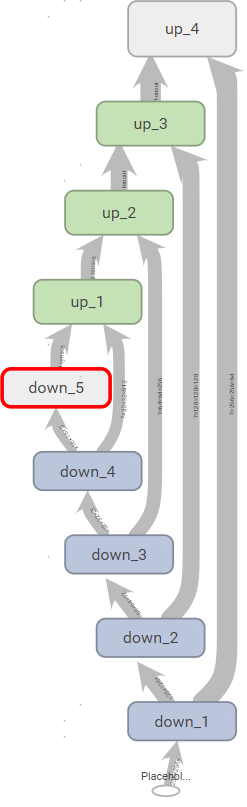

In [66]:
from model import *
from data import trainGenerator
import matplotlib.pyplot as plt


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'train_data/membrane/train','image','label',data_gen_args,save_to_dir = None)
img,mask = next(myGene)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


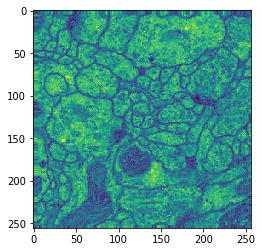

In [68]:
plt.imshow(img[0,:,:,0])

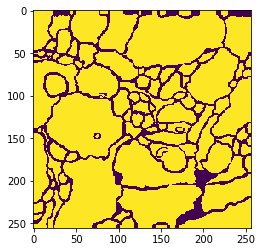

In [69]:
plt.imshow(mask[0,:,:,0])
plt.show()